In [110]:
import torch
from torch import nn 
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torch.optim import Adam

import matplotlib.pyplot as plt
import numpy as np 
from tqdm import tqdm 

Basic idea of GAN is a competition between generator and discriminator 

In [111]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

In [112]:
dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

In [113]:
def output(dataset, limit):
    for i, (x, _) in enumerate(dataset):
        t_x = x.permute(1, 2, 0)
    
        plt.figure(figsize=(10, 6))
    
        plt.subplot(1, 2, 1)
        plt.imshow(t_x, cmap="gray")
        plt.title("Input")
    
        plt.subplot(1, 2, 2)
        plt.imshow(t_x, cmap="gray")
        plt.title("Output")
    
        if i+1 >= limit:
            break
    

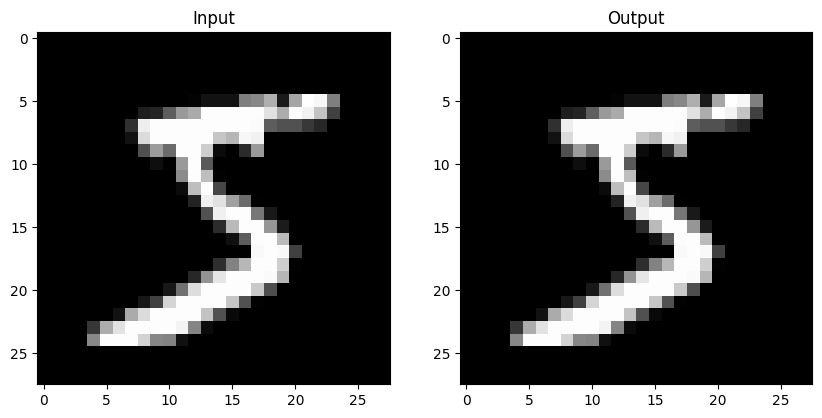

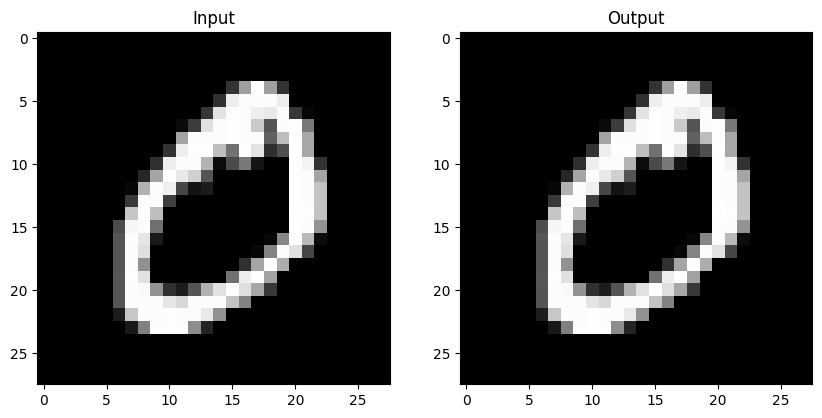

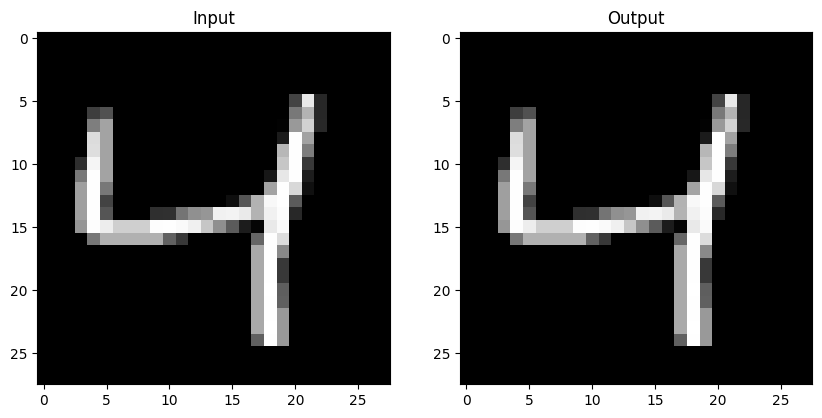

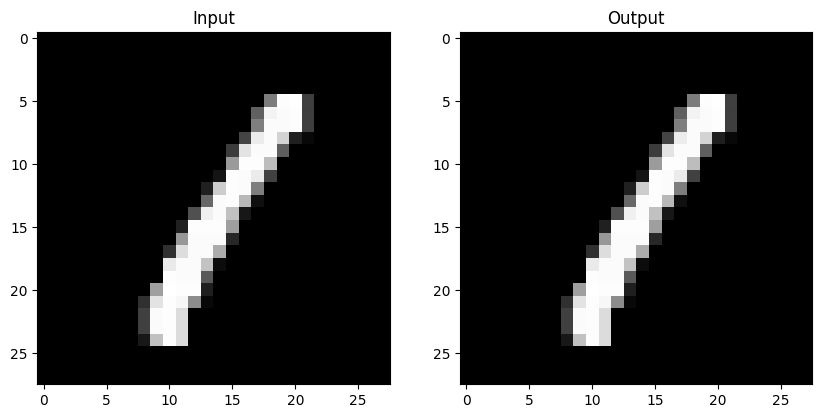

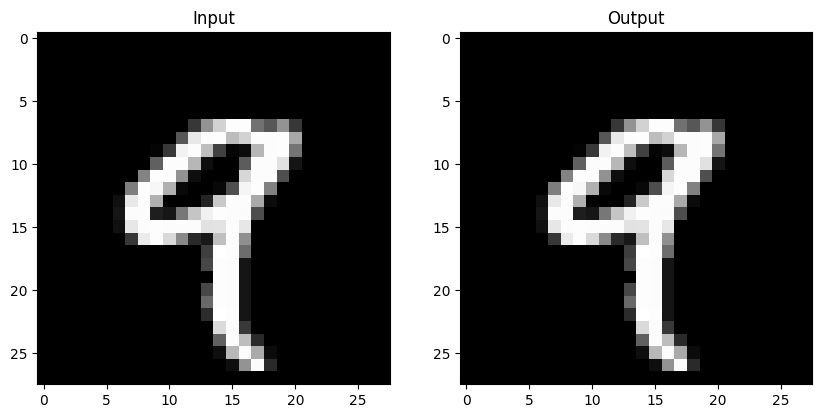

In [114]:
 output(dataset, 5)

In [115]:
x, y = next(iter(dataloader))
x.shape, y.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64]))

In [116]:
class Generator(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()

        self.linear1 = nn.Linear(latent_dim, 256)
        self.linear2 = nn.Linear(256, 512)
        self.linear3 = nn.Linear(512, 1024)
        self.linear4 = nn.Linear(1024, 28*28)

    def forward(self, x):
        out = F.leaky_relu(self.linear1(x))
        out = F.leaky_relu(self.linear2(out))
        out = F.leaky_relu(self.linear3(out))
        out = F.tanh(self.linear4(out))
        res = out.view(out.size(0), *(1, 28, 28))
        return res


class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.linear1 = nn.Linear(1*28*28, 512)
        self.linear2 = nn.Linear(512, 256)
        self.linear3 = nn.Linear(256, 1)
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        out = F.leaky_relu(self.linear1(x))
        out = F.leaky_relu(self.linear2(out))
        res = F.sigmoid(self.linear3(out))
        return res
        
        

In [117]:
discriminator = Discriminator()
generator = Generator()

In [118]:
optimizer_D = Adam(discriminator.parameters(), lr=1e-5, betas=(0.3, 0.999))
optimizer_G = Adam(generator.parameters(), lr=1e-3, betas=(0.3, 0.999))

In [119]:
adv_loss = nn.BCELoss()

In [120]:
# discriminator loss: -0.5 * [log D(x) + log(1-D(G(z)))]
# generator loss: -log(D(G(z)))

# to generate realistic image, generator should work better, that discriminator

def train(epochs, dl, optimizer_D, optimizer_G, adv_loss):
    history = {
        "generator_loss": [],
        "discriminator_loss": []
    }

    for epoch in range(epochs):
        generator_loss = 0
        discriminator_loss = 0
        for x, _ in tqdm(dl):
            reals = torch.ones(x.size(0), 1)
            fakes = torch.zeros(x.size(0), 1)

            optimizer_D.zero_grad()

            # log D(x)
            real_loss = adv_loss(discriminator(x), reals)

            z = torch.rand(x.size(0), 128)
            gen_imgs = generator(z)
            # gen_imgs = D(G(z))

            # log(1-D(G(z)))
            fake_loss = adv_loss(discriminator(gen_imgs.detach()), fakes)

            # -0.5 * [log D(x) + log(1-D(G(z)))]
            d_loss = (real_loss + fake_loss) / 2
            d_loss.backward()
            optimizer_D.step()
            
            discriminator_loss += d_loss.item()

            optimizer_G.zero_grad()
            
            
            # -log(D(G(z)))
            g_loss = adv_loss(discriminator(gen_imgs), reals)
            g_loss.backward()
            optimizer_G.step()

            generator_loss += g_loss.item()

        fin_generator_loss = generator_loss / len(dl)
        fin_discriminator_loss = discriminator_loss / len(dl)

        history["generator_loss"].append(fin_generator_loss)
        history["discriminator_loss"].append(fin_discriminator_loss)

        print(f"Epoch: {epoch+1}, Generator_loss: {fin_generator_loss:.4f}, Discriminator_loss: {fin_discriminator_loss:.4f}")

    return history
    

In [121]:
history = train(30, dataloader, optimizer_D, optimizer_G, adv_loss)

100%|██████████| 938/938 [00:38<00:00, 24.59it/s]


Epoch: 1, Generator_loss: 0.4136, Discriminator_loss: 0.8021


100%|██████████| 938/938 [00:38<00:00, 24.57it/s]


Epoch: 2, Generator_loss: 0.5931, Discriminator_loss: 0.7120


100%|██████████| 938/938 [00:37<00:00, 24.99it/s]


Epoch: 3, Generator_loss: 0.6569, Discriminator_loss: 0.6990


100%|██████████| 938/938 [00:37<00:00, 24.86it/s]


Epoch: 4, Generator_loss: 0.6832, Discriminator_loss: 0.6945


100%|██████████| 938/938 [00:37<00:00, 24.78it/s]


Epoch: 5, Generator_loss: 0.6872, Discriminator_loss: 0.6940


100%|██████████| 938/938 [00:37<00:00, 24.77it/s]


Epoch: 6, Generator_loss: 0.6855, Discriminator_loss: 0.6949


100%|██████████| 938/938 [00:37<00:00, 24.82it/s]


Epoch: 7, Generator_loss: 0.6928, Discriminator_loss: 0.6938


100%|██████████| 938/938 [00:37<00:00, 24.77it/s]


Epoch: 8, Generator_loss: 0.6932, Discriminator_loss: 0.6938


100%|██████████| 938/938 [00:37<00:00, 24.78it/s]


Epoch: 9, Generator_loss: 0.6930, Discriminator_loss: 0.6937


100%|██████████| 938/938 [00:37<00:00, 24.87it/s]


Epoch: 10, Generator_loss: 0.6938, Discriminator_loss: 0.6935


100%|██████████| 938/938 [00:38<00:00, 24.51it/s]


Epoch: 11, Generator_loss: 1.8758, Discriminator_loss: 0.4251


100%|██████████| 938/938 [00:37<00:00, 24.74it/s]


Epoch: 12, Generator_loss: 6.3062, Discriminator_loss: 0.0028


100%|██████████| 938/938 [00:37<00:00, 25.02it/s]


Epoch: 13, Generator_loss: 7.9249, Discriminator_loss: 0.0005


100%|██████████| 938/938 [00:37<00:00, 24.91it/s]


Epoch: 14, Generator_loss: 8.9540, Discriminator_loss: 0.0002


100%|██████████| 938/938 [00:37<00:00, 24.93it/s]


Epoch: 15, Generator_loss: 9.8160, Discriminator_loss: 0.0001


100%|██████████| 938/938 [00:37<00:00, 24.98it/s]


Epoch: 16, Generator_loss: 10.5622, Discriminator_loss: 0.0000


100%|██████████| 938/938 [00:37<00:00, 24.87it/s]


Epoch: 17, Generator_loss: 11.2377, Discriminator_loss: 0.0000


100%|██████████| 938/938 [00:38<00:00, 24.68it/s]


Epoch: 18, Generator_loss: 11.8775, Discriminator_loss: 0.0000


100%|██████████| 938/938 [00:37<00:00, 24.94it/s]


Epoch: 19, Generator_loss: 12.4832, Discriminator_loss: 0.0000


100%|██████████| 938/938 [00:37<00:00, 24.92it/s]


Epoch: 20, Generator_loss: 13.0631, Discriminator_loss: 0.0000


100%|██████████| 938/938 [00:37<00:00, 25.05it/s]


Epoch: 21, Generator_loss: 13.6303, Discriminator_loss: 0.0000


100%|██████████| 938/938 [00:37<00:00, 24.78it/s]


Epoch: 22, Generator_loss: 14.1873, Discriminator_loss: 0.0000


100%|██████████| 938/938 [00:37<00:00, 24.81it/s]


Epoch: 23, Generator_loss: 14.7343, Discriminator_loss: 0.0000


100%|██████████| 938/938 [00:38<00:00, 24.42it/s]


Epoch: 24, Generator_loss: 15.2806, Discriminator_loss: 0.0000


100%|██████████| 938/938 [00:37<00:00, 24.80it/s]


Epoch: 25, Generator_loss: 15.8152, Discriminator_loss: 0.0000


100%|██████████| 938/938 [00:37<00:00, 24.93it/s]


Epoch: 26, Generator_loss: 16.3412, Discriminator_loss: 0.0000


100%|██████████| 938/938 [00:38<00:00, 24.68it/s]


Epoch: 27, Generator_loss: 16.8557, Discriminator_loss: 0.0000


100%|██████████| 938/938 [00:37<00:00, 24.81it/s]


Epoch: 28, Generator_loss: 17.3538, Discriminator_loss: 0.0000


100%|██████████| 938/938 [00:38<00:00, 24.66it/s]


Epoch: 29, Generator_loss: 17.8314, Discriminator_loss: 0.0000


100%|██████████| 938/938 [00:38<00:00, 24.61it/s]

Epoch: 30, Generator_loss: 18.2917, Discriminator_loss: 0.0000


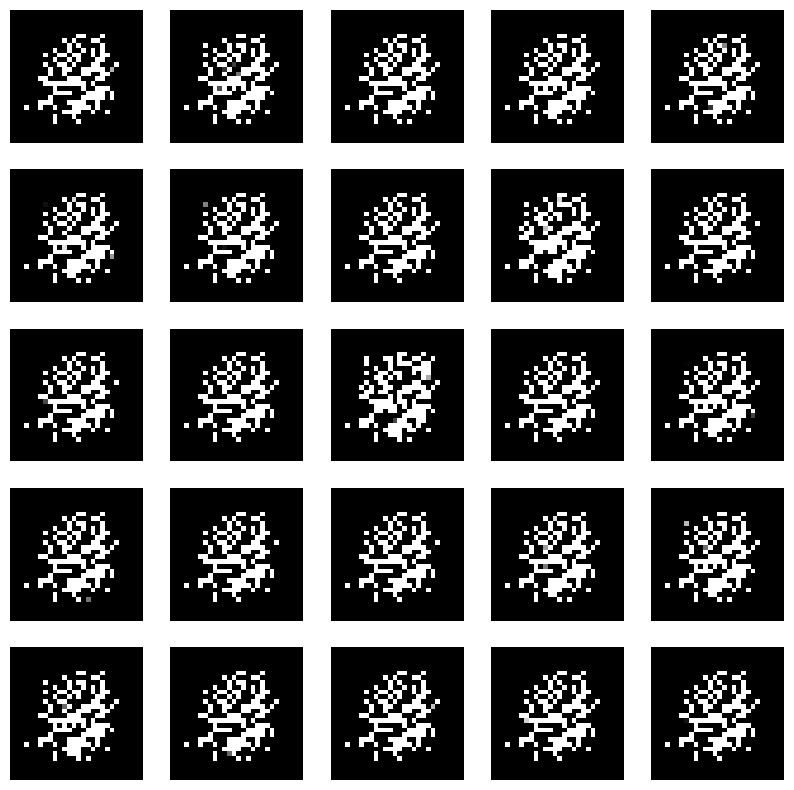

In [127]:
z = torch.randn(25, 128)
gen_imgs = generator(z)
gen_imgs = gen_imgs.squeeze().detach().cpu().numpy()
# print(gen_imgs.shape)

plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(gen_imgs[i], cmap="gray")
    plt.axis("off")
plt.show()